In [1]:
import tensorflow as tf # Models ran in venv python 3.9.16 with GPU computing support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import ast
import ecg_plot
print(tf.config.list_physical_devices()) # Verify you have a GPU available. Not required
print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [2]:
sr = 100

In [3]:
with tf.device('/CPU:0'):
    ### Loading raw data into mutable Datframes
    ptb = pd.read_csv('../data/ptbxl_database.csv')
    def load_raw_data(df, sampling_rate, path):
        if(sampling_rate == 100):
            data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
        else:
            data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
        data = np.array([signal for signal, meta in data])
        return data
    
    # load and convert annotation data
    Y = pd.read_csv('../data/ptbxl_database.csv', index_col='ecg_id')
    Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

    # Load raw signal data
    X = load_raw_data(Y, sr, '../data/')

    # Load scp_statements.csv for diagnostic aggregation
    agg_df = pd.read_csv('../data/scp_statements.csv', index_col=0)
    agg_df = agg_df[agg_df.diagnostic == 1]

    def aggregate_diagnostic(y_dic):
        tmp = []
        for key in y_dic.keys():
            if key in agg_df.index:
                tmp.append(agg_df.loc[key].diagnostic_class)
        return list(set(tmp))


    # Apply diagnostic superclass
    Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [4]:
import numpy as np
from scipy import signal

def normalize(X, shape = False):
    # Compute mean and standard deviation along axis 1 and 2
    X_mean = np.mean(X)
    X_std = np.std(X)

    if(shape):
        print(X.shape)
    # Normalize data by subtracting mean and dividing by standard deviation
    return ((X - X_mean) / X_std)

#____________________________________________________________________________________#

bld = 0.5
def baseline_drift(X, baseline, range = 0):
    bld_range = (baseline-range, baseline+range)
    random_shifts = np.random.uniform(bld_range[0], bld_range[1], size = X.shape)
    return X + random_shifts

#____________________________________________________________________________________#

# Define the filter parameters
fs = 100  # Sampling frequency (Hz)
lowcut = 0.5  # Lower cutoff frequency (Hz)
highcut = 40.0  # Higher cutoff frequency (Hz)
filter_order = 4  # Filter order

def bandpass(X, fs, lowcut, highcut, filter_order):
    # Apply bandpass filter to each channel
    filtered_data = np.zeros_like(X)
    for i in range(X.shape[2]):
        for j in range(X.shape[0]):
            b, a = signal.butter(filter_order, [lowcut, highcut], fs=fs, btype='band', output='ba')
            filtered_data[j, :, i] = signal.filtfilt(b, a, X[j, :, i])

    # Print the shape of the filtered data
    return filtered_data

#____________________________________________________________________________________#

def da_apply(X, functions, shape = False):
    X_final = X.copy()

    # Applys DA Augments in specified order
    for func_dict in functions:
        func = func_dict['func']
        if(func_dict['params'] == None):
            X_final = func(X_final)     
        else:
            params = func_dict['params']
            X_final = func(X_final, *params)  

    if(shape == True):
        print(X_final.shape)

    return X_final

#func_dict = [{'func': normalize, 'params': [None]}]

#func_dict = [{'func': baseline_drift, 'params': [0,0.05]}]

# func_dict =[{'func': normalize, 'params': [None]},
#             {'func': bandpass, 'params': [100, 0.5, 10, 3]}, # 100, 0.5, 10, 3
#             {'func': baseline_drift, 'params': [0,0.075]}]

In [5]:
with tf.device('/CPU:0'):
    func_dict =[{'func': normalize, 'params': [None]},  # Normalizing across the entire data set instead of by lead
                {'func': baseline_drift, 'params': [0,0.075]}]  # I found that simulating a 0.075 drift works best

    X_downsampled = da_apply(X, func_dict) # If you want to experiment with data shape more, use a smaller data size. Subset X

In [56]:
age_model = tf.keras.models.load_model("../saved_models/100hz/age_models/model_1.h5")
sex_model = tf.keras.models.load_model("../saved_models/100hz/sex_models/model_1.h5")

In [61]:
sample_index = 0  # Choose the desired sample index
input_data = X_downsampled[sample_index:sample_index + 1]  # Shape: (1, 1000, 12)
input_data_tensor = tf.convert_to_tensor(input_data, dtype=tf.float32)
input_data_tensor.shape

TensorShape([1, 1000, 12])

In [97]:
with tf.GradientTape() as tape:
    tape.watch(input_data_tensor)
    predictions = sex_model(input_data_tensor)
    target_class_score = predictions[0, 0]


target_class_score

<tf.Tensor: shape=(), dtype=float32, numpy=0.9835908>

In [98]:
with tf.device('/CPU:0'):
    gradients = tape.gradient(target_class_score, input_data_tensor)


In [353]:
gradients[:,:,0].shape

TensorShape([1, 1000])

In [354]:
weights = tf.reduce_mean(gradients, axis=0)
weights.shape

TensorShape([1000, 12])

In [355]:
heatmap = tf.reduce_sum(input_data_tensor * weights, axis=-1).numpy()
heatmap.shape

(1, 1000)

In [356]:
heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
heatmap.shape

(1, 1000)

In [357]:
np.min(weights)

-0.0039526243

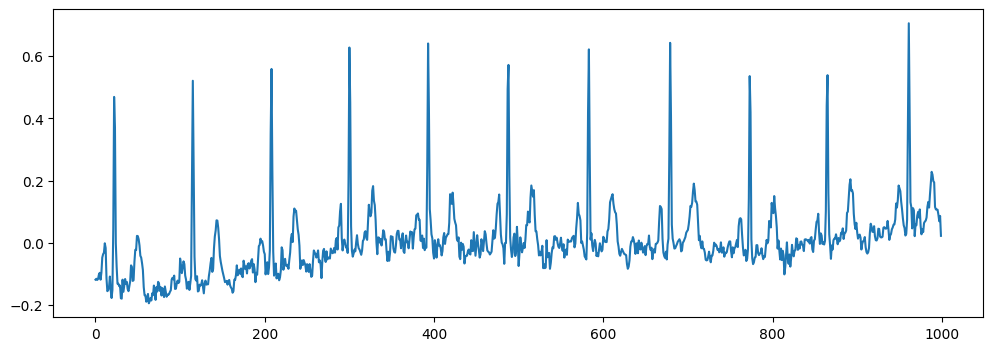

In [358]:
plt.figure(figsize=(12, 4))
plt.plot(X[sample_index, :, 0])

In [359]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection


colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # Blue, White, Red
custom_cmap = LinearSegmentedColormap.from_list('CustomColormap', colors, N=256)

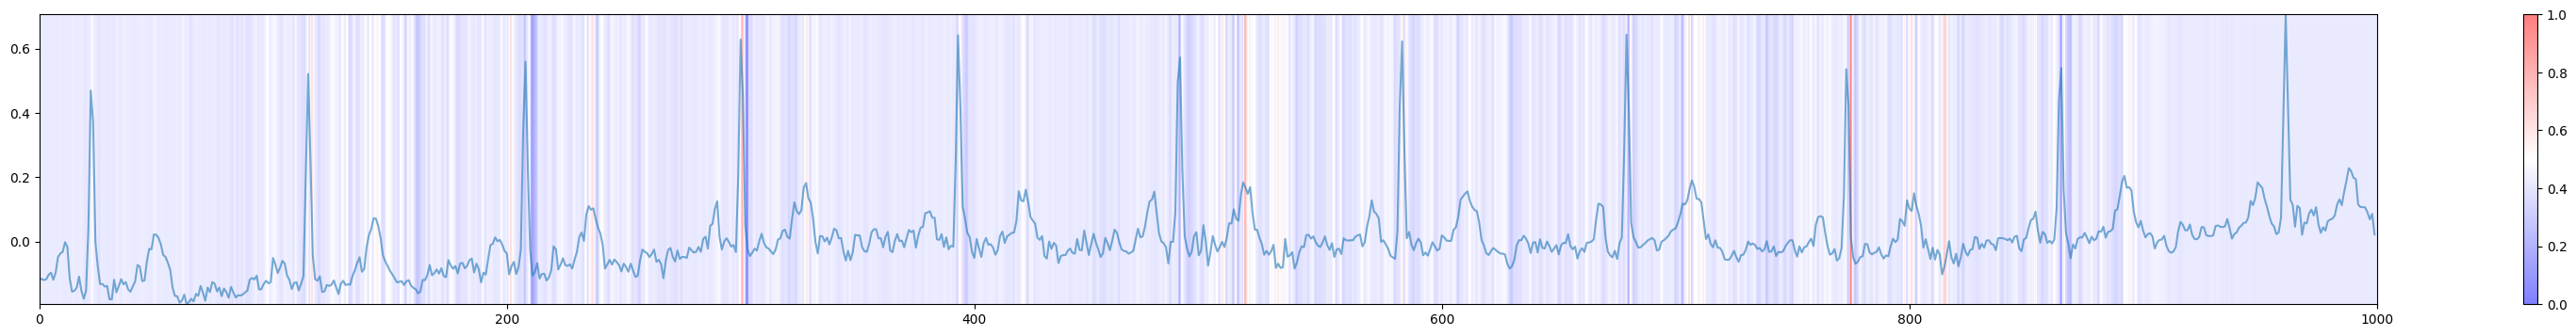

In [362]:
plt.figure(figsize=(40, 4))
plt.gca().set_aspect(0.001)

plt.plot(X[sample_index, :, 0], alpha = 0.6)
plt.imshow(heatmap_norm[0, :, None].T, cmap=custom_cmap, alpha=0.5, extent=[0, 1000, np.min(X[sample_index, :, 0]), np.max(X[sample_index, :, 0])], aspect='auto')
plt.colorbar()
plt.show()

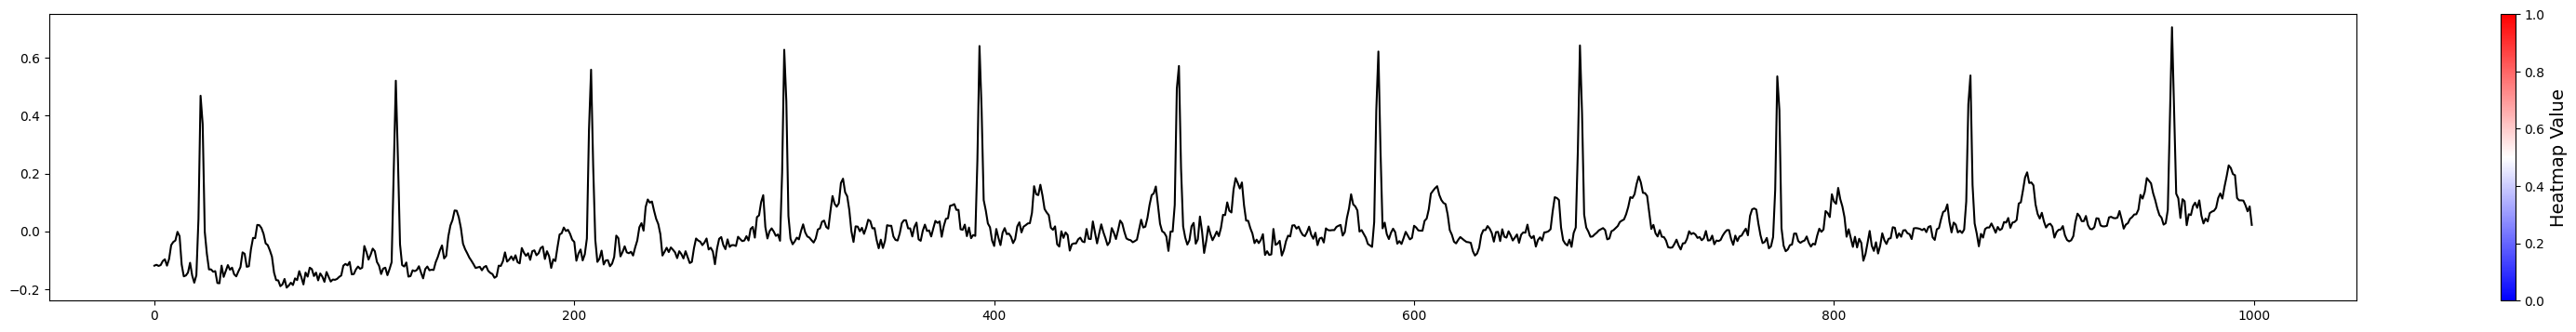

In [233]:
sample_index = 0

# Plot the ECG signal with the heatmap colors
fig, ax = plt.subplots(figsize=(40, 4))
ax.set_aspect('auto')

# Plot the ECG signal using LineCollection with colors from the heatmap
segments = np.array([np.arange(X.shape[1]), X[sample_index, :, 0]]).T.reshape(-1, 1, 2)
lc = LineCollection(segments, cmap=custom_cmap, norm=plt.Normalize(0, 1))
lc.set_array(heatmap[sample_index])
ax.add_collection(lc)

# Plot the ECG signal separately (without colors)
plt.plot(X[sample_index, :, 0], color='black', alpha=1)

# Set the colorbar
cbar = fig.colorbar(lc, ax=ax)
cbar.set_label('Heatmap Value', fontsize=14)

# Show the plot
plt.show()

ValueError: not enough values to unpack (expected 2, got 1)

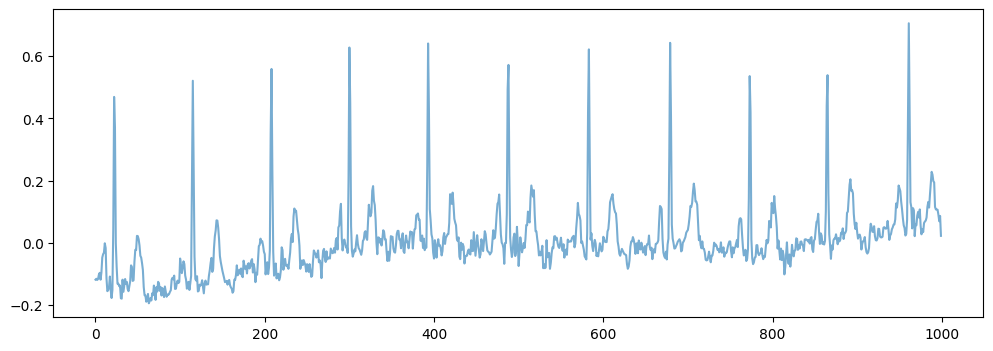

In [269]:

# Define a custom colormap for the heatmap
colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # Blue, White, Red
custom_cmap = LinearSegmentedColormap.from_list('CustomColormap', colors, N=256)

# Plot the ECG signal with the heatmap
plt.figure(figsize=(12, 4))
plt.plot(X[sample_index, :, 0], alpha=0.6)
plt.pcolormesh(np.arange(X.shape[1]), np.arange(X.shape[0]), heatmap[0], cmap=custom_cmap, alpha=0.5)
plt.colorbar(label='Heatmap Value', fraction=0.02)
plt.xlabel('Time')
plt.ylabel('ECG Signal')
plt.show()

In [268]:
heatmap[0].shape

(1000,)

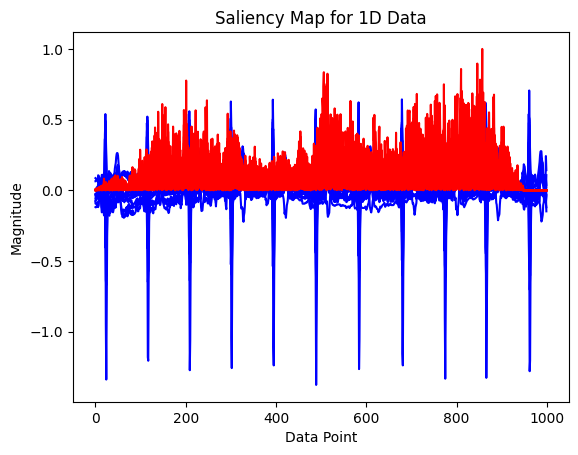

In [248]:
saliency_map = np.abs(gradients)
saliency_map = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map))

# Plot the saliency map
plt.plot(X[0], color='blue', label='Data')
plt.plot(saliency_map[0], color='red', label='Saliency Map')
plt.xlabel('Data Point')
plt.ylabel('Magnitude')
plt.title('Saliency Map for 1D Data')
plt.show()

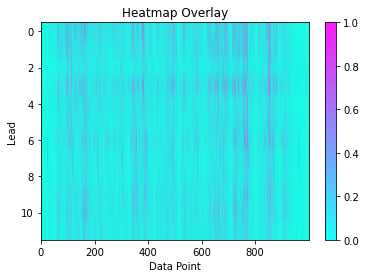

In [296]:
plt.imshow(X[0].T, cmap='hot', aspect='auto')
plt.imshow(saliency_map[0].T, cmap='cool', alpha=0.9, aspect='auto')
plt.colorbar()
plt.xlabel('Data Point')
plt.ylabel('Lead')
plt.title('Heatmap Overlay')
plt.show()


In [262]:
# normalized_gradients = tf.math.abs(gradients)  # Assuming single sample, adjust if necessary
# max_gradient = tf.reduce_max(normalized_gradients)
# normalized_gradients /= max_gradient
# saliency_map = normalized_gradients.numpy()
# gradient_map = np.abs(gradients[0]).mean(axis=1)
# sm = saliency_map[0, :,1].reshape(-1,1)
# saliency_map.shape

(1, 1000, 12)

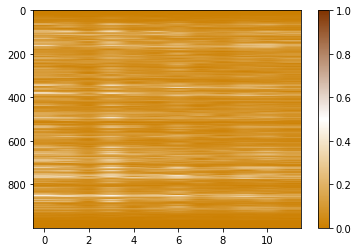

In [268]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(0.8, 0.5, 0), (1,1,1), (0.5, 0.2,0)]  # Define the desired colors
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
plt.imshow(saliency_map[0], cmap=cmap, aspect = 'auto')
plt.colorbar()
plt.show()

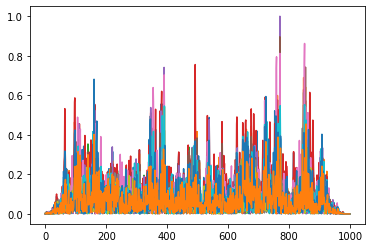

In [264]:
plt.plot(saliency_map[0])
plt.show()

In [377]:
ecg_signal = X[sample_index, :, 0]

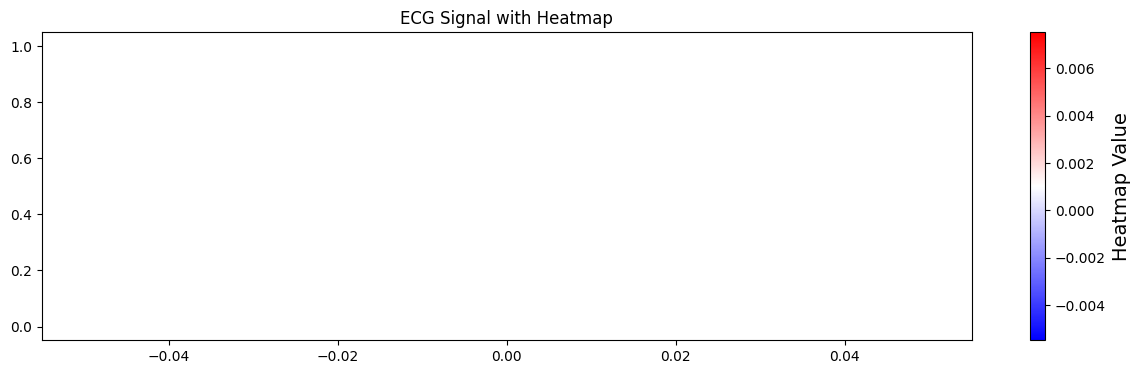

In [433]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the ECG signal with the heatmap colors
def plot_ecg_with_heatmap(ecg_signal, heatmap, cmap, title=''):
    fig, ax = plt.subplots(figsize=(15, 4))

    # Plot the ECG signal as a line plot
    ax.plot(ecg_signal, color='black', linewidth=1)

    # Normalize the heatmap to (0, 1)
    heatmap_min = np.min(heatmap)
    heatmap_max = np.max(heatmap)
    normalized_heatmap = (heatmap - heatmap_min) / (heatmap_max - heatmap_min)

    # Overlay the heatmap using colored segments
    for i in range(len(ecg_signal) - 1):
        segment_x = [i, i + 1]
        segment_y = [ecg_signal[i], ecg_signal[i + 1]]
        segment_color = cmap(normalized_heatmap[i])
        ax.fill_between(segment_x, segment_y, ecg_signal.min(), color=segment_color)

    # Set the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(heatmap_min, heatmap_max))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Heatmap Value', fontsize=14)

    plt.title(title)
    plt.show()

# Assuming heatmap is already computed as in your code
# heatmap = ...

# Assuming you have the ECG signal data as a numpy array of shape (1000,)
# ecg_signal = ...

# Assuming you have a custom_cmap defined
# custom_cmap = ...

# Plot the ECG signal with the heatmap colors
plot_ecg_with_heatmap(ecg_signal, heatmap, custom_cmap, title='ECG Signal with Heatmap')


In [411]:
heatmap.shape

(1, 1000)

### Meshgrid test

In [434]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define your CNN model (replace with your actual CNN model architecture)
def create_cnn_model():
    # Define your CNN layers here
    pass

# Load your trained CNN model
ecg_sex_model_2 = tf.keras.models.load_model("../saved_models/100hz/sex_models/model_1.h5")
ecg_sex_model_2.load_weights("../saved_models/100hz/sex_models/model_1.h5")  # Load the model weights

# Define the Grad-CAM function
def grad_cam(model, input_data, target_class):
    # Convert the input_data to a TensorFlow tensor
    input_data = tf.convert_to_tensor(input_data, dtype=tf.float32)

    # Record operations for gradient calculation
    input_data = tf.Variable(input_data, trainable=True)

    # Forward pass
    with tf.GradientTape() as tape:
        predictions = model(input_data)
        target_score = predictions[:, target_class]

    # Calculate gradients of the target score with respect to the input_data
    gradients = tape.gradient(target_score, input_data)

    # Calculate the importance scores
    importance_scores = tf.reduce_mean(gradients, axis=1).numpy()

    return importance_scores

# Assuming you have a single ECG signal from your dataset (replace with your actual ECG data)
# ecg_signal = ...

# Choose the target class for which you want to visualize the contribution map
target_class = 0  # Replace 0 with the desired class index

# Get the importance scores using Grad-CAM
importance_scores = grad_cam(ecg_sex_model_2, np.expand_dims(X[0, :, 0], axis=0), target_class)

# Plot the ECG signal
plt.figure(figsize=(10, 6))
plt.plot(ecg_signal[0], color='blue', label='ECG Signal')

# Plot the contribution map on top of the ECG signal
plt.imshow([importance_scores], cmap='jet', aspect='auto', alpha=0.7, extent=[0, 1000, 0, 1], vmin=0, vmax=1)

# Add labels, legend, and show the plot
plt.xlabel('Time')
plt.ylabel('ECG Signal')
plt.title(f'Contribution Map for Class {target_class}')
plt.colorbar(label='Importance Score')
plt.legend()
plt.show()


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [438]:
X.shape

(1, 1000)